## How to generate pulsar frequencies


**Note: the methods in this notebook have been usurped by XXX**



This notebook explores how to take some pulsar data (`.tim` and `.par` files) from the [IPTA Mock Data Challenge](https://web.archive.org/web/20130108011819/http://www.ipta4gw.org/?page_id=126) (see also [https://github.com/nanograv/mdc1](https://github.com/nanograv/mdc1)) and generate some frequencies $f$ for use with state-space methods like Kalman filtering.

It is a pedagogical guide, heavily based off of [guidance from L. Dunn](https://gist.github.com/ldunn/0ee22b40397965f4644ea8d1bc2f1a77)

---


## 1. Imports and setup

We use the [libstempo](https://github.com/vallis/libstempo) python wrapper for `tempo2`. Specifically we use L.Dunn's branch, see [Liam's installation notes](https://gist.github.com/ldunn/04a20627941df1a7f96f6fd5a0a291b9).

When importing `tempo2` we have to set the `TEMPO2` environment variable. We don't have to do this when working directly in the shell, but inside a Jupyter notebook [it seems necessary (?!)](https://github.com/microsoft/vscode/issues/163612)

In [2]:
import os 
os.environ['TEMPO2'] = '/fred/oz022/tkimpson/tempo2/T2runtime' # set the environment variable
import libstempo

## 2. Generating TOAs

Lets look at how to generate some TOAs using our data files + `libstempo`


In [3]:
# First define the data to use
import glob
path_to_data = '../mdc/IPTA_Challenge1_open/Challenge_Data/Dataset1/'
list_of_par_files = sorted(glob.glob(path_to_data+'/*.par'))
list_of_tim_files = sorted(glob.glob(path_to_data+'/*.tim'))
assert len(list_of_par_files) == len(list_of_tim_files)

In [4]:
#Pick a particular pulsar
psr_idx = 0
par_file = list_of_par_files[psr_idx]
tim_file = list_of_tim_files[psr_idx]

In [5]:
#Generate a tempopulsar object 
psr = libstempo.tempopulsar(parfile=par_file,timfile=tim_file)

/tmp/ipykernel_117122/3471839918.py:2: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = libstempo.tempopulsar(parfile=par_file,timfile=tim_file)


[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 


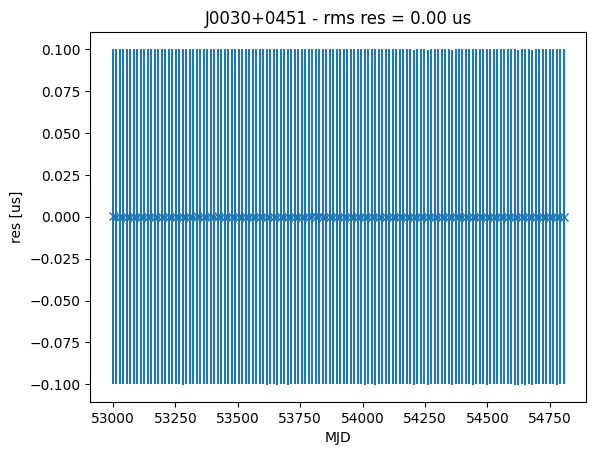

In [6]:
import libstempo.toasim as toasim
import libstempo.plot

toasim.make_ideal(psr) # make_ideal shifts the ToAs so that they are exactly aligned with the timing model we loaded
toasim.make_ideal(psr) # For whatever reason doing two passes of make_ideal gets a better result - with just one you can end up with a slight trend in the residuals
libstempo.plot.plotres(psr)


i.e. zero residuals with some error bars. This makes sense because the TOAs were generated via the timing model and so agree exactly.

## 3. Adding noise 


Now lets add some noise to these TOAs. We are interested in 3 different types:

* White noise (i.e. measurement noise)
* Red noise (uncorrelated between PSRs) i.e. intrinstic pulsar spin noise 
* Red noise (correlated between PSRs) i.e. the stochastic GW background 

We use libstempo to add thees noises. See https://github.com/vallis/libstempo/blob/master/libstempo/toasim.py

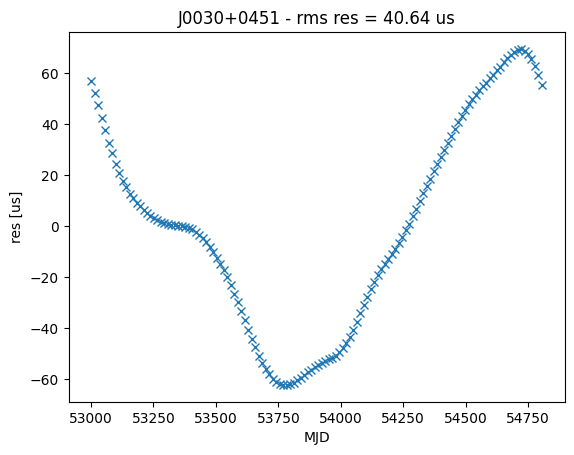

In [7]:
#Parameters

## Random seeding
noise_seed = 1

## GW parameters
alpha=-2/3 # this is defined as being negative
gw_amplitude = 5e-14

## Red noise parameters
gamma = 4 #...this is positive
A = 1e-12


## White noise parameters
### to do. One can define an efac parameter to scale the errors to be what you want. For now, lets just leave them as in the .tim file 


## Now add noise 
toasim.add_rednoise(psr,A, gamma,seed=noise_seed)                    # Add some red noise 
toasim.add_efac(psr,seed=noise_seed)                                 # Add white noise at the level specified in the .tim file
toasim.add_gwb(psr,seed=noise_seed, gwAmp=gw_amplitude, alpha=alpha) # add GW backgriund given an amplitude and an index


libstempo.plot.plotres(psr)





Now we can see that the residuals are not zero. This makes sense - there is lots of noise that hasn't been accounted for.

## 4. Generating frequencies


Given these TOAs that are perturbed by different noise processes, we want to obtain a frequency timeseries $f(t)$ to be ingested by the Kalman filter.

Lets define $$f(t) = \frac{\Delta \phi}{\Delta t}=\frac{\phi(t_{i+1}) - \phi({t_i})}{t_{i+1} - t_{i}}$$

Text(0, 0.5, 'Phase [rad]')

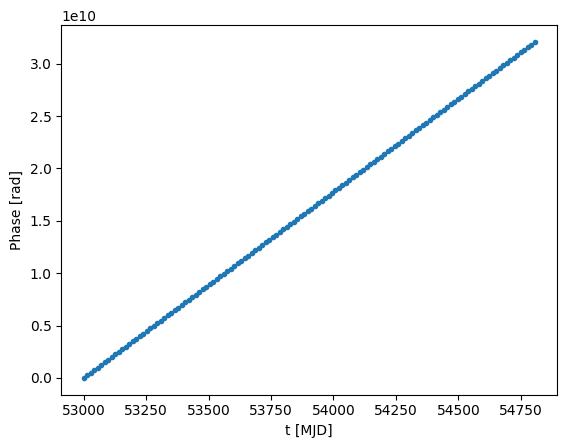

In [8]:
import matplotlib.pyplot as plt 
pulsar_emission_times = psr.pets()         # PET for Pulsar Emission Time - these are the ToAs in the pulsar frame
pulse_number          = psr.pulsenumbers()  # These are the pulse numbers for each ToA --- i.e. the (inferred) absolute phase at each ToA. This is what you really want to use as your phase measurement

plt.plot(pulsar_emission_times,pulse_number,'.')
plt.xlabel('t [MJD]')
plt.ylabel('Phase [rad]') 

In [9]:
import numpy as np 
dt = np.diff(pulsar_emission_times)*86400 # PETs are in MJD so multiply by 86400 to get seconds
dphi = np.diff(pulse_number)
f = dphi / dt 

#Consider the frequencies to be evaluated at the lower end of the box - arbitrary
t_eval = pulsar_emission_times[0:-1]
assert len(f) == len(t_eval)

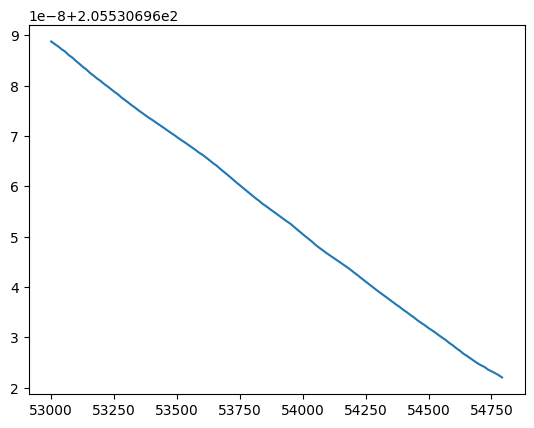

In [10]:
plt.plot(t_eval,f)

We can see that the frequency calculated this way is somewhere around 205 Hz. Does this match (roughly) with the frequency in the par file?

In [11]:
psr['F0'].val

205.53069608827311754

In [12]:
psr.name 

'J0030+0451'

Yes! To the eye the curve looks spin-down-y and wiggle-y which is also what one might expect intuitively and very similar to the Ornstein-Uhlenbeck stuff that we are used to dealing with.